# Notebook to explore the potential use of GPU for AT2017gfo PE

In [2]:
# Basic imports
import numpy as np
import pandas as pd
import os
import arviz
import time
import copy
import inspect 
from jax.scipy.stats import truncnorm
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
# matlotlib settings
params = {"axes.grid": True,
        "text.usetex" : False, # TODO enable latex, but this breaks if filters have underscore
        "font.family" : "serif",
        "ytick.color" : "black",
        "xtick.color" : "black",
        "axes.labelcolor" : "black",
        "axes.edgecolor" : "black",
        "font.serif" : ["Computer Modern Serif"],
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
        "axes.labelsize": 16,
        "legend.fontsize": 16,
        "legend.title_fontsize": 16,
        "figure.titlesize": 16}
plt.rcParams.update(params)

# NMMA imports
import nmma as nmma
from nmma.em.io import loadEvent
from nmma.em.model import SVDLightCurveModel
from nmma.em.utils import get_calc_lc_jit
from nmma.em.io import read_photometry_files
from nmma.em.utils import interpolate_nans
import nmma.em.model_parameters as model_parameters

MODEL_FUNCTIONS = {
    k: v for k, v in model_parameters.__dict__.items() if inspect.isfunction(v)
}
model_name = "Bu2022Ye"
model_function = MODEL_FUNCTIONS[model_name]

# flowMC imports
from flowMC.nfmodel.rqSpline import MaskedCouplingRQSpline
from flowMC.sampler.Gaussian_random_walk import GaussianRandomWalk
from flowMC.sampler.MALA import MALA
from flowMC.sampler.Sampler import Sampler
from flowMC.utils.PRNG_keys import initialize_rng_keys
from flowMC.nfmodel.utils import *

# jax imports
import jax
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_debug_nans", False)
import jaxlib
import jax.numpy as jnp
print("Checking if CUDA is found:")
print(jax.devices())

/home/urash/twouters/miniconda3/envs/nmma_gpu/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Explore data

Load in the data

**TODO**: for now, I am ignoring non inf datapoints for simplicity. Have to extend to include inf datapoints as well.

**TODO**: Not sure if t can also be just the times we want to have, i.e., the times of the datapoints? Can reduce memory and improve efficiency>?

In [ ]:
data_file = "../data/AT2017gfo_no_inf.dat"
trigger_time = 57982.5285236896
tmin, tmax = 0.05, 14
data = loadEvent(data_file)
# Read the LC dataset and interpolate the NaNs, and get training data
lcs_dir = "/home/urash/twouters/KN_Lightcurves/lightcurves/lcs_bulla_2022" # for remote SSH Potsdam
filenames = os.listdir(lcs_dir)
full_filenames = [os.path.join(lcs_dir, f) for f in filenames]
lc_dataset = read_photometry_files(full_filenames)
lc_dataset = interpolate_nans(lc_dataset)
training_data, parameters = model_function(lc_dataset)
filters = list(data.keys())
print("Filters:")
print(filters)

sample_times = jnp.linspace(tmin, tmax, 1000)

Filters:
['ps1__g', 'ps1__r', 'ps1__i', 'ps1__z', 'ps1__y', '2massj', '2massh', '2massks', 'sdssu']


Plot the data

No handles with labels found to put in legend.


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Serif


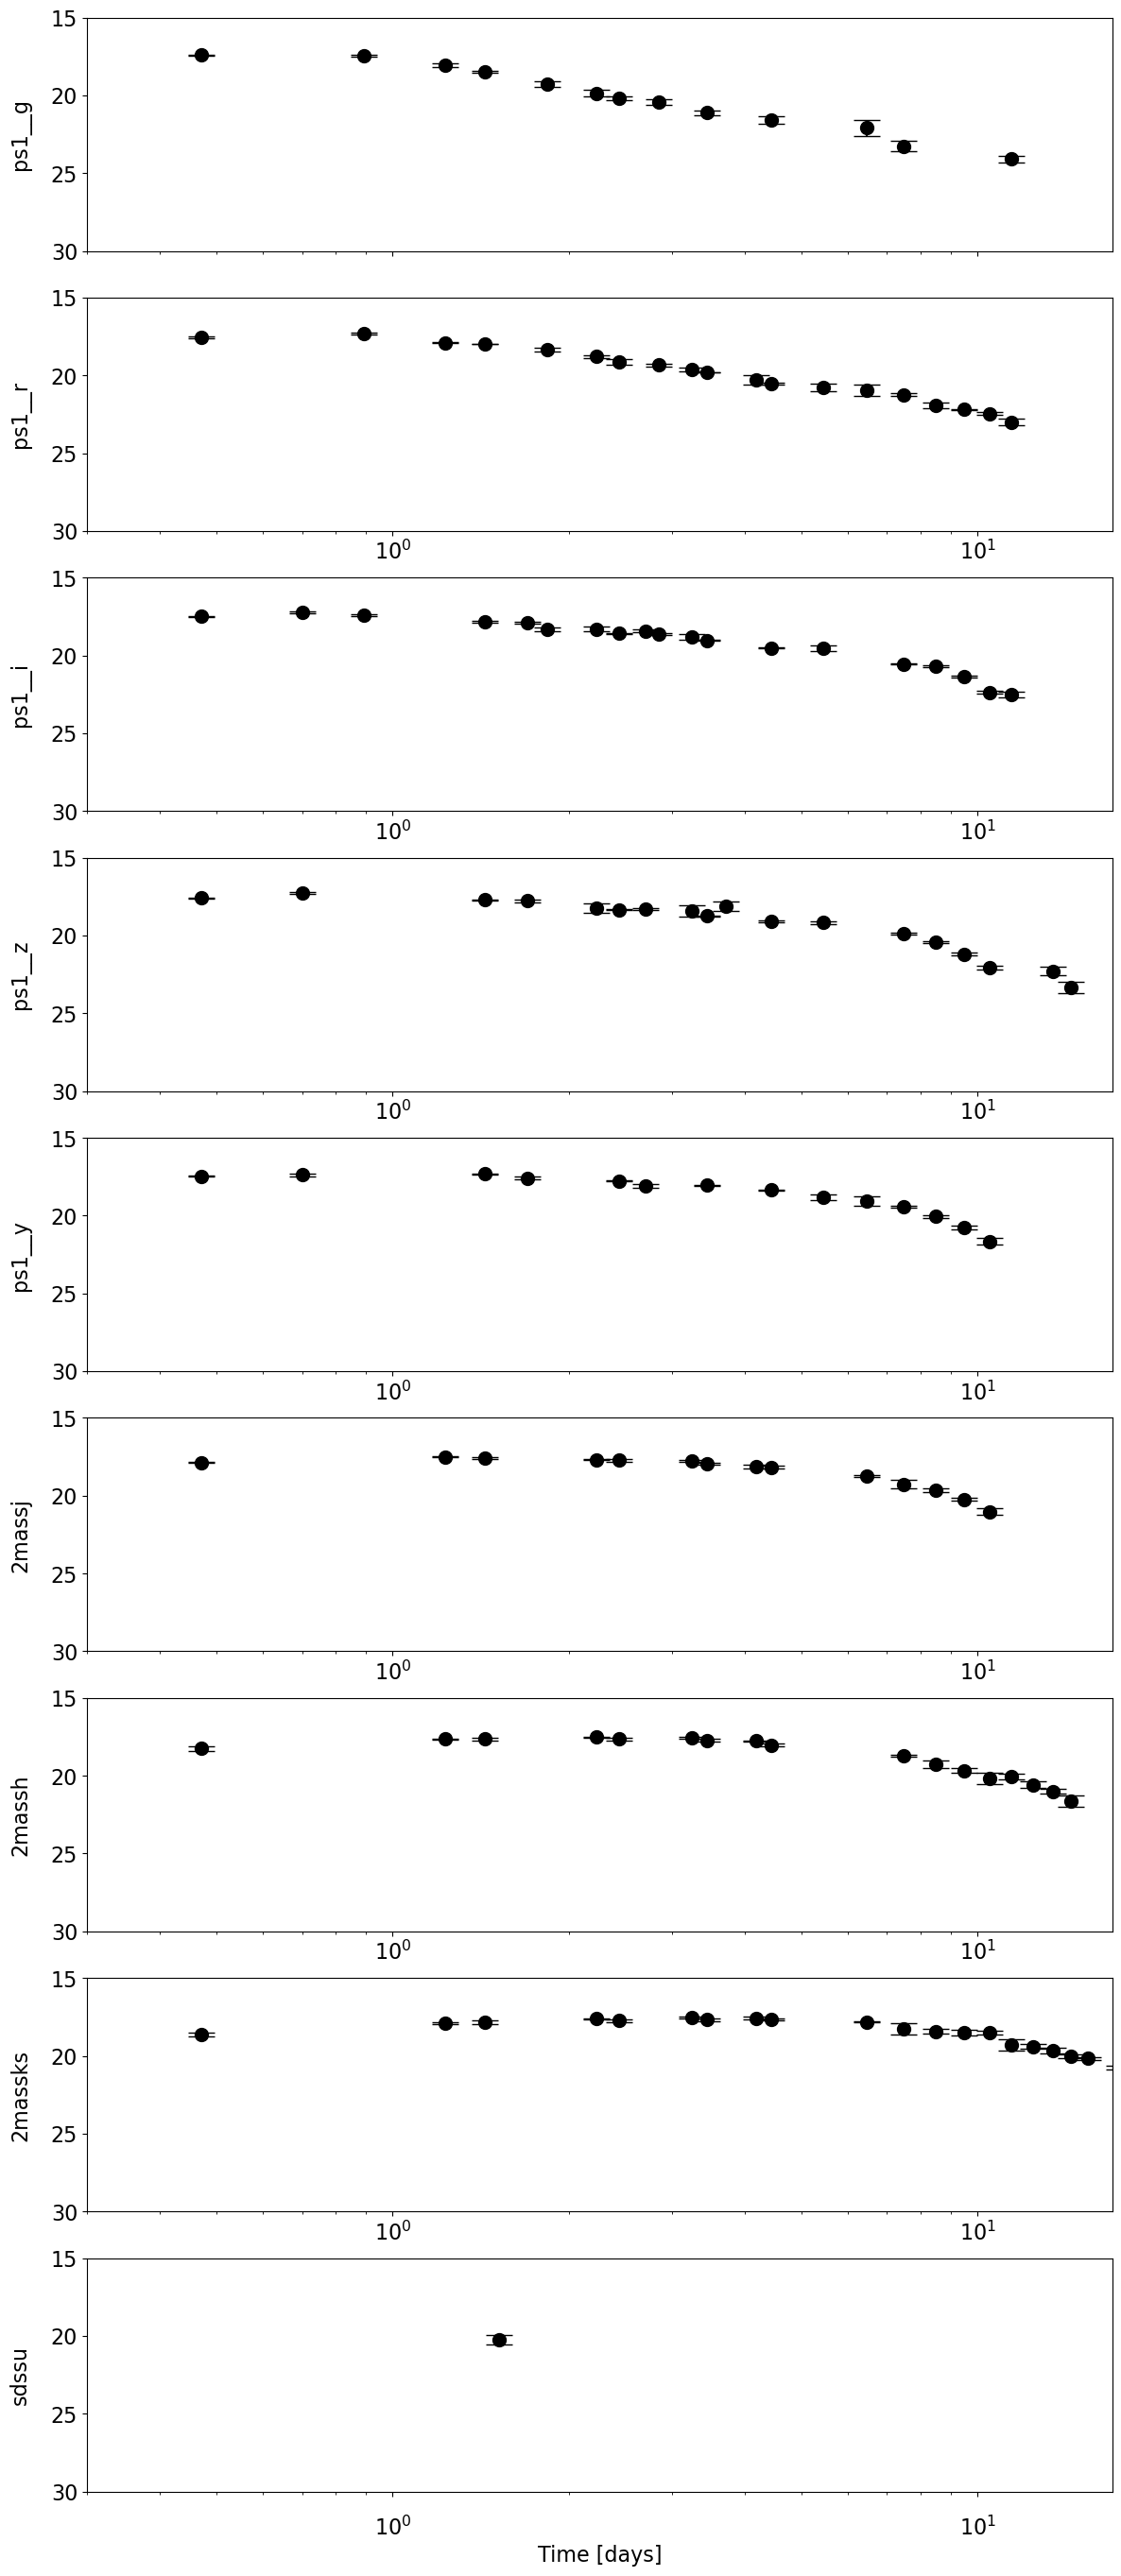

In [ ]:
### Plot hyperparameters
set_ylim = True
set_yticks = True
show_legend = False
show_data = False

error_budget = '1.0'
error_budget = [float(x) for x in error_budget.split(",")]
error_budget = dict(zip(filters, error_budget * len(filters)))
xlim = f"{tmin},{tmax}"
ylim = "32, 15"
x_left = 3e-1
x_right = tmax + 3

# colors = cm.Spectral(np.linspace(0, 1, len(filters)))[::-1]

plt.figure(figsize=(14, 34))

cnt = 0
for filt in filters:
    cnt = cnt + 1
    if cnt == 1:
        ax1 = plt.subplot(len(filters), 1, cnt)
    elif cnt == 2 or cnt == 3:
        ax2 = plt.subplot(len(filters), 1, cnt, sharex=ax1)
    else:
        ax2 = plt.subplot(len(filters), 1, cnt, sharex=ax1)

    samples = data[filt]
    t, y, sigma_y = copy.deepcopy(samples[:, 0]), copy.deepcopy(samples[:, 1]), copy.deepcopy(samples[:, 2])
    t -= trigger_time   
    idx = np.where(~np.isnan(y))[0]
    t, y, sigma_y = t[idx], y[idx], sigma_y[idx]

    # 1) plot data points
    idx = np.where(np.isfinite(sigma_y))[0]
    plt.errorbar(t[idx], y[idx], sigma_y[idx], fmt="o", color='k', markersize=10, capsize=10)
    # plot upper bounds
    idx = np.where(~np.isfinite(sigma_y))[0]
    plt.errorbar(t[idx], y[idx], sigma_y[idx], fmt="v", color='k', markersize=10, capsize=10)

    #plt.ylim([float(x) for x in ylim.split(",")])
    plt.xlim([float(x) for x in xlim.split(",")])
    plt.xscale('log')
    plt.grid()
    
    filt_label = filt
    
    if cnt == 1:
        
        plt.ylabel(filt_label, rotation=90, labelpad=15)
        if set_ylim:
            ax1.set_ylim([30,15])
        #plt.ylim([float(x) for x in ylim.split(",")])
    else:
        # filt_label = filt.replace("__", "-")
        plt.ylabel(filt_label, rotation=90, labelpad=15)
        if set_ylim:
            ax2.set_ylim([30,15])
        #plt.ylim([float(x) for x in ylim.split(",")])

    if cnt == 1:
        if set_yticks:
            ax1.set_yticks([30, 25, 20, 15])
        else:
            ax1.invert_yaxis()
        ax1.set_xlim(left=x_left, right=x_right)
        plt.setp(ax1.get_xticklabels(), visible=False)
        legend = plt.legend(loc = "center", bbox_to_anchor=(0.5, 1.2), shadow=False,
                            fancybox=True, ncol=4)
        legend.get_frame().set_alpha(None)
    else:
        if set_yticks:
            ax2.set_yticks([30, 25, 20, 15])
        else:
            ax2.invert_yaxis()
        ax2.set_xlim(left=x_left, right=x_right)
    

ax1.set_zorder(1)
plt.xlabel("Time [days]")
ax2.tick_params(axis='x', which='major', pad=15)
#plt.legend(bbox_to_anchor=(0., 12.9, 1.025, .0), ncol=2, fontsize=40, frameon=True)
#plt.tight_layout()
plt.subplots_adjust(hspace=0.2, wspace=0)

if not show_legend:
    legend.remove()

if show_data:
    plt.show()

## LC model

In [ ]:
svd_path = "/home/urash/twouters/nmma_models/flax_models/"

lc_model = SVDLightCurveModel(
        model_name,
        t,
        svd_path=svd_path,
        parameter_conversion=None,
        mag_ncoeff=10,
        lbol_ncoeff=None,
        interpolation_type="flax",
        model_parameters=None,
        filters=filters,
        local_only=True
)

/home/urash/twouters/nmma_models/flax_models/Bu2022Ye.pkl


Function to generate light curves with jit:

NOTE: sample times must be the same here as within the log-likelihood call, it cannot be changed for now.

In [ ]:
from nmma.em.utils import calc_lc_flax

calc_lc_given_params = lambda x: calc_lc_flax(sample_times, x, svd_mag_model=lc_model.svd_mag_model, svd_lbol_model=None, mag_ncoeff=10, lbol_ncoeff=None, filters=filters)

## Using the NMMA function
# calc_lc_given_params_jit = get_calc_lc_jit(sample_times, svd_mag_model=lc_model.svd_mag_model, filters=filters)

## Jitting myself here:
calc_lc_given_params_jit = jax.jit(calc_lc_given_params)

# test it:
test_params = jnp.array([-2.30103, 0.12, 0.3, -1.30103, 0.03, 25.84])
_, _, test_lc = calc_lc_given_params_jit(test_params)
# TODO is this correct?
# Convert from jax numpy to just numpy
test_lc_np = {f: np.asarray(test_lc[f]) for f in filters}

# test_lc_np

## Inference with flowMC

### Priors

Look at `/home/urash/twouters/gpu_projects/KN_inference/cpu/priors/AT2017gfo_Bu2022Ye_uniform_iota.prior`:
```markdown
luminosity_distance = 44
inclination_EM = Uniform(name='inclination_EM', minimum=0., maximum=np.pi/2., latex_label='$\\iota$')
log10_mej_dyn  = Uniform(name='log10_mej_dyn', minimum=-3, maximum=-1.7, latex_label='$\\log_{10}M^{\\rm{dyn}}_{\\rm{ej}}$')
vej_dyn = Uniform(name='vej_dyn', minimum=0.12, maximum=0.25, latex_label='$V^{\\rm{dyn}}_{\\rm{ej}}$')
Yedyn = Uniform(name='Yedyn', minimum=0.15, maximum=0.3, latex_label='$Y_{\\rm{e}}$')
log10_mej_wind = Uniform(name='log10_mej_wind', minimum=-2, maximum=-0.89, latex_label='$\\log_{10}M^{\\rm{wind}}_{\\rm{ej}}$')
vej_wind = Uniform(name='vej_wind', minimum=0.03, maximum=0.15, latex_label='$V^{\\rm{wind}}_{\\rm{ej}}$')
```

In [ ]:
print(parameters)
prior_range = jnp.array([[-3, 1.7], [0.12, 0.25], [0.15, 0.3], [-2, 0.89], [-2, -0.89], [0, jnp.pi / 2]])
n_dim = len(prior_range)

['log10_mej_dyn', 'vej_dyn', 'Yedyn', 'log10_mej_wind', 'vej_wind', 'KNtheta']


In [ ]:
def top_hat(x):
    output = 0.
    for i in range(n_dim):
        output = jax.lax.cond(x[i]>=prior_range[i,0], lambda: output, lambda: -jnp.inf)
        output = jax.lax.cond(x[i]<=prior_range[i,1], lambda: output, lambda: -jnp.inf)
    return output

### Likelihood

In [ ]:
def truncated_gaussian(m_det, m_err, m_est, lim):

    a, b = (-jnp.inf - m_est) / m_err, (lim - m_est) / m_err
    logpdf = truncnorm.logpdf(m_det, a, b, loc=m_est, scale=m_err)

    return logpdf

In [ ]:
# Make data a jnp array
for filt in filters:
    data[filt] = jnp.asarray(data[filt])

In [ ]:
# TODO change this: we are toying with the compute LC function

# calc_lc_function = calc_lc_given_params_jit
calc_lc_function = calc_lc_given_params

def get_chisq_filt(mag_abs, 
                   sample_times,
                   data_time, 
                   data_mag, 
                   data_sigma,
                   t0: float = 0.0,
                   error_budget: float = 1.0,
                   luminosity_distance = 44.0):
    
    """
    Function taken from nmma/em/likelihood.py and adapted to this case here
    
    This is a piece of the log likelihood function, which is the sum of the chisquare for a single filter, to decompose the likelihood calculation.
    """
    
    # TODO non-zero time
    # TODO include non-trivial error budget

    # Calculate apparent magnitude
    mag_app = mag_abs + 5.0 * jnp.log10(
        luminosity_distance * 1e6 / 10.0
    )
    
    # Limit to finite magnitudes
    # TODO implement check for finite
    sample_times_used = sample_times
    mag_app_used = mag_app
    
    # Add the error budget to the sigma
    data_sigma = jnp.sqrt(data_sigma ** 2 + error_budget ** 2)

    # Evaluate the light curve magnitude at the data points
    mag_est = jnp.interp(data_time, sample_times_used + t0, mag_app_used, left="extrapolate", right="extrapolate")

    # TODO get detection limit?
    detection_limit = jnp.inf
    minus_chisquare = jnp.sum(
        truncated_gaussian(
            data_mag,
            data_sigma,
            mag_est,
            detection_limit,
        )
    )
    
    return minus_chisquare

In [ ]:
def log_likelihood(parameters, luminosity_distance = 44.0):
    """
    Function taken from nmma/em/likelihood.py and adapted to this case here
    
    TODO: 
    - separate LC params from parameters?
    - add error budget
    - add timeshift
    - add luminosity distance
    - this is assuming all data are "finite" and the LC is finite. Not checking this here since breaks JAX jit
    """
    
    # Generate the light curve
    _, _, mag_abs = calc_lc_function(parameters)
    
    minus_chisquare_total = 0.0
    for filt in filters:
        # Decompose the data of this filter
        data_time, data_mag, data_sigma  = copy.deepcopy(data[filt]).T
        mag_abs_filt = mag_abs[filt]
        # Compute the chi squared for this filter
        chisq_filt = get_chisq_filt(mag_abs_filt, sample_times, data_time, data_mag, data_sigma, luminosity_distance = luminosity_distance)
        minus_chisquare_total += chisq_filt

    log_prob = minus_chisquare_total

    return log_prob

#### Debugging

Idea: check if gradient on truncated gaussian gives NaNs?

In [ ]:
# Get some dummy values for the parameters
filt = filters[0]
data_mag = copy.deepcopy(data[filt][:, 1])
data_sigma = copy.deepcopy(data[filt][:, 2])
error_budget = 1.0
detection_limit = jnp.inf
data_sigma = jnp.sqrt(data_sigma ** 2 + error_budget ** 2)

# dummy estimated magnitudes
mag_est = data_mag + 0.1

def test_truncated_gaussian(data_mag,
            data_sigma,
            mag_est,
            detection_limit):
    """
    Test the truncated gaussian function
    """

    return jnp.sum(
        truncated_gaussian(
            data_mag,
            data_sigma,
            mag_est,
            detection_limit,
        )
    )

In [ ]:
print(test_truncated_gaussian(data_mag, data_sigma, mag_est, detection_limit))
print(jax.grad(test_truncated_gaussian)(data_mag, data_sigma, mag_est, detection_limit))

-12.304478773133997
[0.09996002 0.09936407 0.09858044 0.09984026 0.09719118 0.09577627
 0.09880447 0.0975039  0.0975039  0.09538344 0.07871537 0.08963786
 0.09615385]


Checking likelihood computation and gradient

In [ ]:
# jax.make_jaxpr(log_likelihood)(test_params)

In [ ]:
# jax.make_jaxpr(jax.grad(log_likelihood))(test_params)

In [ ]:
# print(parameters)
# nmma_params = jnp.array([-2.22, 0.12, 0.3, -1.15, 0.03, 25.84])

print("Test for random params")
test_logL = log_likelihood(test_params)
print(test_logL)

# print("Test for params from NMMA")
# test_logL = log_likelihood(nmma_params)
# print(nmma_logL)


Test for random params
-87354960718.77606


In [ ]:
test_dv_logL = jax.grad(log_likelihood)(test_params)
print(test_dv_logL)

### Posterior

In [ ]:
def posterior(theta, data):
    # NOTE: the data argument is unused?
    prior = top_hat(theta)
    return log_likelihood(theta) + prior

### Set up sampler

Initial position of chains

In [ ]:
n_chains = 100

rng_key_set = initialize_rng_keys(n_chains, seed=42)

initial_position = jax.random.uniform(rng_key_set[0], shape=(int(n_chains), n_dim)) * 1
for i in range(n_dim):
    initial_position = initial_position.at[:,i].set(initial_position[:,i]*(prior_range[i,1]-prior_range[i,0])+prior_range[i,0])

In [ ]:
model = MaskedCouplingRQSpline(n_dim, 10, [128,128], 8, jax.random.PRNGKey(42))

print("Initializing sampler class")

mass_matrix = jnp.eye(n_dim)
eps = 1e-3
# TODO any tuning to be done here?
posterior = posterior

local_sampler_arg = {"step_size": mass_matrix * eps}
use_jit = True
# local_sampler = MALA(posterior, use_jit, local_sampler_arg) ## TODO derivative is broken so MALA is broken
local_sampler = GaussianRandomWalk(posterior, use_jit, {"step_size": eps})

Initializing sampler class


### Run the sampler

In [ ]:
nf_sampler = Sampler(
    n_dim,
    rng_key_set,
    None,
    local_sampler,
    model,
    n_loop_training=50,
    n_loop_production=10,
    n_local_steps=20,
    n_global_steps=20,
    n_chains=n_chains,
    n_epochs=100,
    learning_rate=0.001,
    max_samples=50000,
    momentum=0.9,
    batch_size=50000,
    use_global=True,
    keep_quantile=0.0,
    train_thinning=1,
    output_thinning=1,    
    local_sampler_arg=local_sampler_arg,
    outdir_name="./outdir/"
)

## Run sampler

Note: without jitting, we get more print statements (as expected since that is a byproduct of the function), and the training loop takes around 4 minutes, production loop around 2 mins.

In [ ]:
nf_sampler.sample(initial_position, None)

No autotune found, use input sampler_params
Training normalizing flow


Tuning global sampler: 100%|██████████| 20/20 [15:27<00:00, 46.36s/it]


Starting Production run


Production run: 100%|██████████| 10/10 [00:01<00:00,  7.54it/s]


## Postprocessing

In [ ]:
print("Creating plots")
nf_sampler.plot_summary("training")
nf_sampler.plot_summary("production")

Creating plots


NameError: name 'nf_sampler' is not defined

## TODO, can we do inference with Numpyro?

**TODO**: Install numpyro and make sure it does not break the conda env again

**TODO**: Get likelihood etc?

In [ ]:
# import numpyro
# from numpyro.diagnostics import hpdi, summary
# import numpyro.distributions as dist
# from numpyro import handlers
# from numpyro.infer import MCMC, NUTS
# numpyro.set_platform("gpu")

In [ ]:
# def run_inference(
#     model, num_warmup=1000, num_samples=1000, max_tree_depth=10, dense_mass=False
# ):
#     kernel = NUTS(model, max_tree_depth=max_tree_depth, dense_mass=dense_mass)
#     mcmc = MCMC(
#         kernel,
#         num_warmup=num_warmup,
#         num_samples=num_samples,
#         num_chains=1,
#         progress_bar=False,
#     )
#     mcmc.run(jax.random.PRNGKey(0))
#     summary_dict = summary(mcmc.get_samples(), group_by_chain=False)

#     # print the largest r_hat for each variable
#     for k, v in summary_dict.items():
#         spaces = " " * max(12 - len(k), 0)
#         print("[{}] {} \t max r_hat: {:.4f}".format(k, spaces, np.max(v["r_hat"])))